# 실습 목표

- KorQuAD 데이터를 이용하여 word2vec (skip-gram)을 학습시킨다.
- KorQuAD 데이터를 이용하여 sentencepiece를 학습시킨다.
- KorQuAD 데이터에 POS tagging을 해본다

![nn](img/KQ_01.png)

### 실습 데이터 불러오기

In [1]:
import os
import random
import re
import string
import time
import json

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE

from gensim.models import word2vec
from konlpy.tag import Twitter
import mecab
import sentencepiece as spm

In [2]:
with open('dataset/KorQuAD_v1.0_train.json') as dataset_file:
    dataset_json = json.load(dataset_file)
    dataset = dataset_json['data']

In [3]:
print(type(dataset))

<class 'list'>


In [4]:
print(len(dataset))

1420


In [5]:
print(type(dataset[0]))

<class 'dict'>


In [6]:
dataset[0]

{'paragraphs': [{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'text': '1악장', 'answer_start': 421}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
     'id': '6566495-0-2',
     'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
    {'answers': [{'text': '파우스트', 'answer_start': 15}],
     'id': '6566518-0-0',
     'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
    {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
     'id': '6566518-0-1',
     'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
    {'answers': [{'text': '1839', 'answer_start': 0}],
     'id': '5917067-0-0',
     'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
    {'answers': [{'text': '파리', 'answer_start': 410}],
     'id': '5917067-0-1',
     'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
    {'answers': [{'text': '드레스덴', 'answer_sta

In [7]:
print(dataset[0].keys())

dict_keys(['paragraphs', 'title'])


In [8]:
dataset[0]['title']

'파우스트_서곡'

In [9]:
type(dataset[0]['paragraphs'])

list

In [10]:
len(dataset[0]['paragraphs'])

3

In [11]:
type(dataset[0]['paragraphs'][0])

dict

In [12]:
dataset[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context'])

In [13]:
dataset[0]['paragraphs'][0]['qas']

[{'answers': [{'text': '교향곡', 'answer_start': 54}],
  'id': '6566495-0-0',
  'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
 {'answers': [{'text': '1악장', 'answer_start': 421}],
  'id': '6566495-0-1',
  'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
 {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
  'id': '6566495-0-2',
  'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
 {'answers': [{'text': '파우스트', 'answer_start': 15}],
  'id': '6566518-0-0',
  'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
 {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
  'id': '6566518-0-1',
  'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
 {'answers': [{'text': '1839', 'answer_start': 0}],
  'id': '5917067-0-0',
  'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
 {'answers': [{'text': '파리', 'answer_start': 410}],
  'id': '5917067-0-1',
  'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
 {'answers': [{'text': '드레스덴', 'answer_start': 534}],
  'id': '5917067-0-2',
  'question': '바그너의 1악장의 초연은 어디서 연주되었는가?'}]

In [14]:
dataset[0]['paragraphs'][0]['context']

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [15]:
dataset[0]['paragraphs'][1]['context']

'한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금을 받고 팔았다. 또한 그의 작품을 “하나하나의 음표가 시인의 피로 쓰여졌다”며 극찬했던 한스 폰 뷜로가 그것을 피아노 독주용으로 편곡했는데, 리스트는 그것을 약간 변형되었을 뿐이라고 지적했다. 이 서곡의 총보 첫머리에는 파우스트 1부의 내용 중 한 구절을 인용하고 있다.'

In [16]:
dataset[0]['paragraphs'][2]['context']

'이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다. 주요부는 Sehr bewegt(아주 격동적으로), 2/2박자의 자유로운 소나타 형식으로 매우 드라마틱한 구상과 유기적인 구성을 하고 있다. 여기에는 지금까지의 주제나 소재 외에도 오보에에 의한 선율과 제2주제를 떠올리게 하는 부차적인 주제가 더해지는데, 중간부에서는 약보3이 중심이 되고 제2주제는 축소된 재현부에서 D장조로 재현된다. 마지막에는 주요 주제를 회상하면서 조용히 마친다.'

## 실습1. 한글 데이터를 이용하여 Word2vec (skip-gram) 학습하기

### 전처리 하기

1. KorQuAD 데이터에서, context 부분의 한글만 사용.
2. 가장 간단한 한글 word vector를 위하여, 한글 명사만을 이용하도록 전처리

In [8]:
# 1. Context 부분의 한글만 사용
def normalize_answer(s):
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text)
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)
        text = re.sub('[a-zA-Z0-9]',' ', text)
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [9]:
dataset[0]['paragraphs'][2]['context']

'이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다. 주요부는 Sehr bewegt(아주 격동적으로), 2/2박자의 자유로운 소나타 형식으로 매우 드라마틱한 구상과 유기적인 구성을 하고 있다. 여기에는 지금까지의 주제나 소재 외에도 오보에에 의한 선율과 제2주제를 떠올리게 하는 부차적인 주제가 더해지는데, 중간부에서는 약보3이 중심이 되고 제2주제는 축소된 재현부에서 D장조로 재현된다. 마지막에는 주요 주제를 회상하면서 조용히 마친다.'

In [19]:
normalize_answer(dataset[0]['paragraphs'][2]['context'])

'이 작품은 라단조 아주 신중하게 박자의 부드러운 서주로 서주로 시작되는데 여기에는 주요 주제 동기의 대부분이 암시 예고되어 있다 첫 부분의 저음 주제는 주요 주제 고뇌와 갈망 동기 청춘의 사랑 동기 를 암시하고 있으며 제 바이올린으로 더욱 명확하게 나타난다 또한 그것을 이어받는 동기도 중요한 역할을 한다 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다 주요부는 아주 격동적으로 박자의 자유로운 소나타 형식으로 매우 드라마틱한 구상과 유기적인 구성을 하고 있다 여기에는 지금까지의 주제나 소재 외에도 오보에에 의한 선율과 제 주제를 떠올리게 하는 부차적인 주제가 더해지는데 중간부에서는 약보 이 중심이 되고 제 주제는 축소된 재현부에서 장조로 재현된다 마지막에는 주요 주제를 회상하면서 조용히 마친다'

In [10]:
# 2. 한글 명사만 이용
import mecab
mecab = mecab.MeCab()

In [11]:
mecab.nouns(normalize_answer(dataset[0]['paragraphs'][2]['context']))

['작품',
 '라단조',
 '신중',
 '박자',
 '서주',
 '서주',
 '시작',
 '여기',
 '주요',
 '주제',
 '동기',
 '대부분',
 '암시',
 '예고',
 '부분',
 '저음',
 '주제',
 '주요',
 '주제',
 '고뇌',
 '갈망',
 '동기',
 '청춘',
 '사랑',
 '동기',
 '암시',
 '제',
 '바이올린',
 '그것',
 '동기',
 '중요',
 '역할',
 '여기',
 '소재',
 '뒤',
 '주제',
 '연주',
 '주요부',
 '격동',
 '박자',
 '자유',
 '소나타',
 '형식',
 '구상',
 '유기',
 '구성',
 '여기',
 '지금',
 '주제',
 '소재',
 '외',
 '오보에',
 '선율',
 '주제',
 '부차',
 '주제',
 '중간부',
 '약보',
 '중심',
 '제',
 '주제',
 '축소',
 '재현부',
 '장조',
 '재현',
 '마지막',
 '주요',
 '주제',
 '회상']

In [12]:
sentences = []

for i in range(len(dataset)):
    cur_par = dataset[i]['paragraphs']
    for j in range(len(cur_par)):
        cur_con = cur_par[j]['context']
        temp = [mecab.nouns(normalize_answer(x)) for x in cur_con.split('.')]  # 명사만 추출해서 넣기
        sentences = sentences + temp
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [13]:
print(type(sentences))
print(len(sentences))

<class 'list'>
81103


In [14]:
print(sentences[0])
print(sentences[1])
print(sentences[2])

['년', '바그너', '괴테', '파우스트', '내용', '마음', '이', '소재', '하나', '교향곡', '뜻']
['시기', '바그너', '년', '빛', '독촉', '산전수전', '상황', '좌절', '실망', '메피스토펠레스', '파우스트', '심경', '공감']
['파리', '브네', '크', '지휘', '파리', '음악원', '관현악단', '연주', '베토벤', '교향곡', '번', '감명', '이것', '이듬해', '월', '파우스트', '서곡', '작품', '조금', '영향', '것', '의심', '여지']


# Word vector 학습

![nn](img/KQ_02.PNG)

In [15]:
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  

In [16]:
# 파라메터값 지정
num_features = 100 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 단어빈도수가 10으로 제한
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [17]:
start_time = time.time()
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)
end_time= time.time()
print((end_time - start_time))

11.353524684906006


In [18]:
# skip_gram 학습 model 저장
skip_gram.save('skip_gram_01_5epoch.model')

In [19]:
# skip_gram 학습 model 불러오기
skip_gram = word2vec.Word2Vec.load('materials/skip_gram_01.model')

In [20]:
# 가장 의미가 가까운 단어 찾기
skip_gram.wv.most_similar('학원')

[('재단법인', 0.5910211801528931),
 ('전문학교', 0.5876554250717163),
 ('대학', 0.5831794738769531),
 ('대학교', 0.5719953179359436),
 ('大學', 0.540473997592926),
 ('설립', 0.5359161496162415),
 ('개교', 0.5351823568344116),
 ('학교', 0.5218689441680908),
 ('김연준', 0.5160139799118042),
 ('學校', 0.5148331522941589)]

In [21]:
# 단어들의 linear operation이 가능해짐.
vec = skip_gram['우정'] + skip_gram['남자'] + skip_gram['여자']

In [22]:
skip_gram.wv.similar_by_vector(vec, topn=10, restrict_vocab=None)

[('남자', 0.8085622787475586),
 ('여자', 0.8041542768478394),
 ('우정', 0.7401790618896484),
 ('친구', 0.6232176423072815),
 ('주인공', 0.596595048904419),
 ('남녀', 0.5908113718032837),
 ('사랑', 0.5700591206550598),
 ('연애', 0.5535998940467834),
 ('연기', 0.5432729721069336),
 ('맥그리거', 0.5309441089630127)]

In [25]:
# 가장 의미가 가까운 단어 찾기
skip_gram.wv.most_similar('바그너')

[('바이로이트', 0.6369321346282959),
 ('말러', 0.635749340057373),
 ('교향곡', 0.5732250809669495),
 ('초연', 0.5445836186408997),
 ('브람스', 0.5384786128997803),
 ('라이프치히', 0.5367981195449829),
 ('슈트라우스', 0.5287472605705261),
 ('리하르트', 0.5286892652511597),
 ('재연', 0.5088880062103271),
 ('연주회', 0.5083446502685547)]

In [31]:
# 단어들의 linear operation이 가능해짐.
vec = skip_gram['오바마'] - skip_gram['미국'] + skip_gram['한국']
skip_gram.wv.similar_by_vector(vec, topn=10, restrict_vocab=None)

[('오바마', 0.9182342290878296),
 ('버락', 0.6380590200424194),
 ('상원', 0.5062373876571655),
 ('대통령', 0.46813976764678955),
 ('박근혜', 0.46513551473617554),
 ('문재인', 0.45452073216438293),
 ('엄마', 0.4519421458244324),
 ('최진실', 0.44379377365112305),
 ('의원', 0.44366270303726196),
 ('일리노이', 0.4427304267883301)]

### Quiz
- 모든 상상력을 동원하여, 자신만의 흥미로운 연산 결과를 찾아주세요!

### word vector 학습결과 시각화

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

import matplotlib.font_manager as fm

path = 'materials/NanumBarunGothic.ttf'

fontprop = fm.FontProperties(fname=path, size=10)

def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30, fontproperties=fontprop) # 각 scatter들에대해 단어 labeling

    plt.show()

In [33]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=50) # k개의 임의 단어를 랜덤 샘플링

In [34]:
len(vocab)

10782

In [35]:
print(random_vocab)

['아우스터리츠', '의료법', '취임', '메들리', '총알', '고노', '출루율', '소득', '수주', '연장', '코디', '실존', '분출', '오늘', '흑', '문무', '시설물', '불', '거절', '경찰관', '퍼', '집', '샌디에이고', '라즈베리', '살상', '여행', '全', '디렉터', '추', '구두', '국왕', '허락', '플레이', '남부', '그리스도교', '폭주', '사인', '업자', '용기', '어휘', '양극', '작중', '그분', '꼬리', '철강', '삶', '잠자리', '매직', '홈구장', '식량']


In [36]:
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기

In [37]:
print(type(word_emb))
print(word_emb.shape)
print(word_emb[0])

<class 'numpy.ndarray'>
(50, 100)
[-0.71391517 -0.3745007  -0.0366935   1.2163739   0.5432779  -0.6200657
  0.58924294  0.20266777 -0.08730634  0.04833519  0.25935006 -0.15925713
 -0.45206538  1.0816426   0.19804856  0.1952744  -0.19497974  0.870473
 -0.5720274   0.20199189 -0.91248816  0.59174716  0.51225847 -0.5877441
 -0.45751914  0.01091398  1.0428425  -0.20887537  1.1653229   0.06166669
 -0.40050784  0.5448458  -0.28377134  0.02195966 -0.0192488   0.5298235
  0.29786685 -0.24955781  0.23592663  0.777314   -0.8211023   0.20384486
  1.4033432   0.13511209  0.4467234   0.44456372 -0.30071634 -0.55652475
  0.6355447  -0.41268852 -1.1101992  -0.24685697 -0.63425887 -0.7611221
 -0.5896742   0.52806205 -1.0481783   0.35711822 -0.21034491 -0.3719702
 -0.5336808  -0.9430366  -0.07318295  0.07968558  0.02628755  0.9601653
 -0.3395956   0.06196317 -0.7959245  -0.08416923 -0.7096781   0.12575664
 -0.73552597 -0.04346272 -0.5315825   0.32084525  0.58865875 -0.8232771
  0.07752944  0.04271058 -

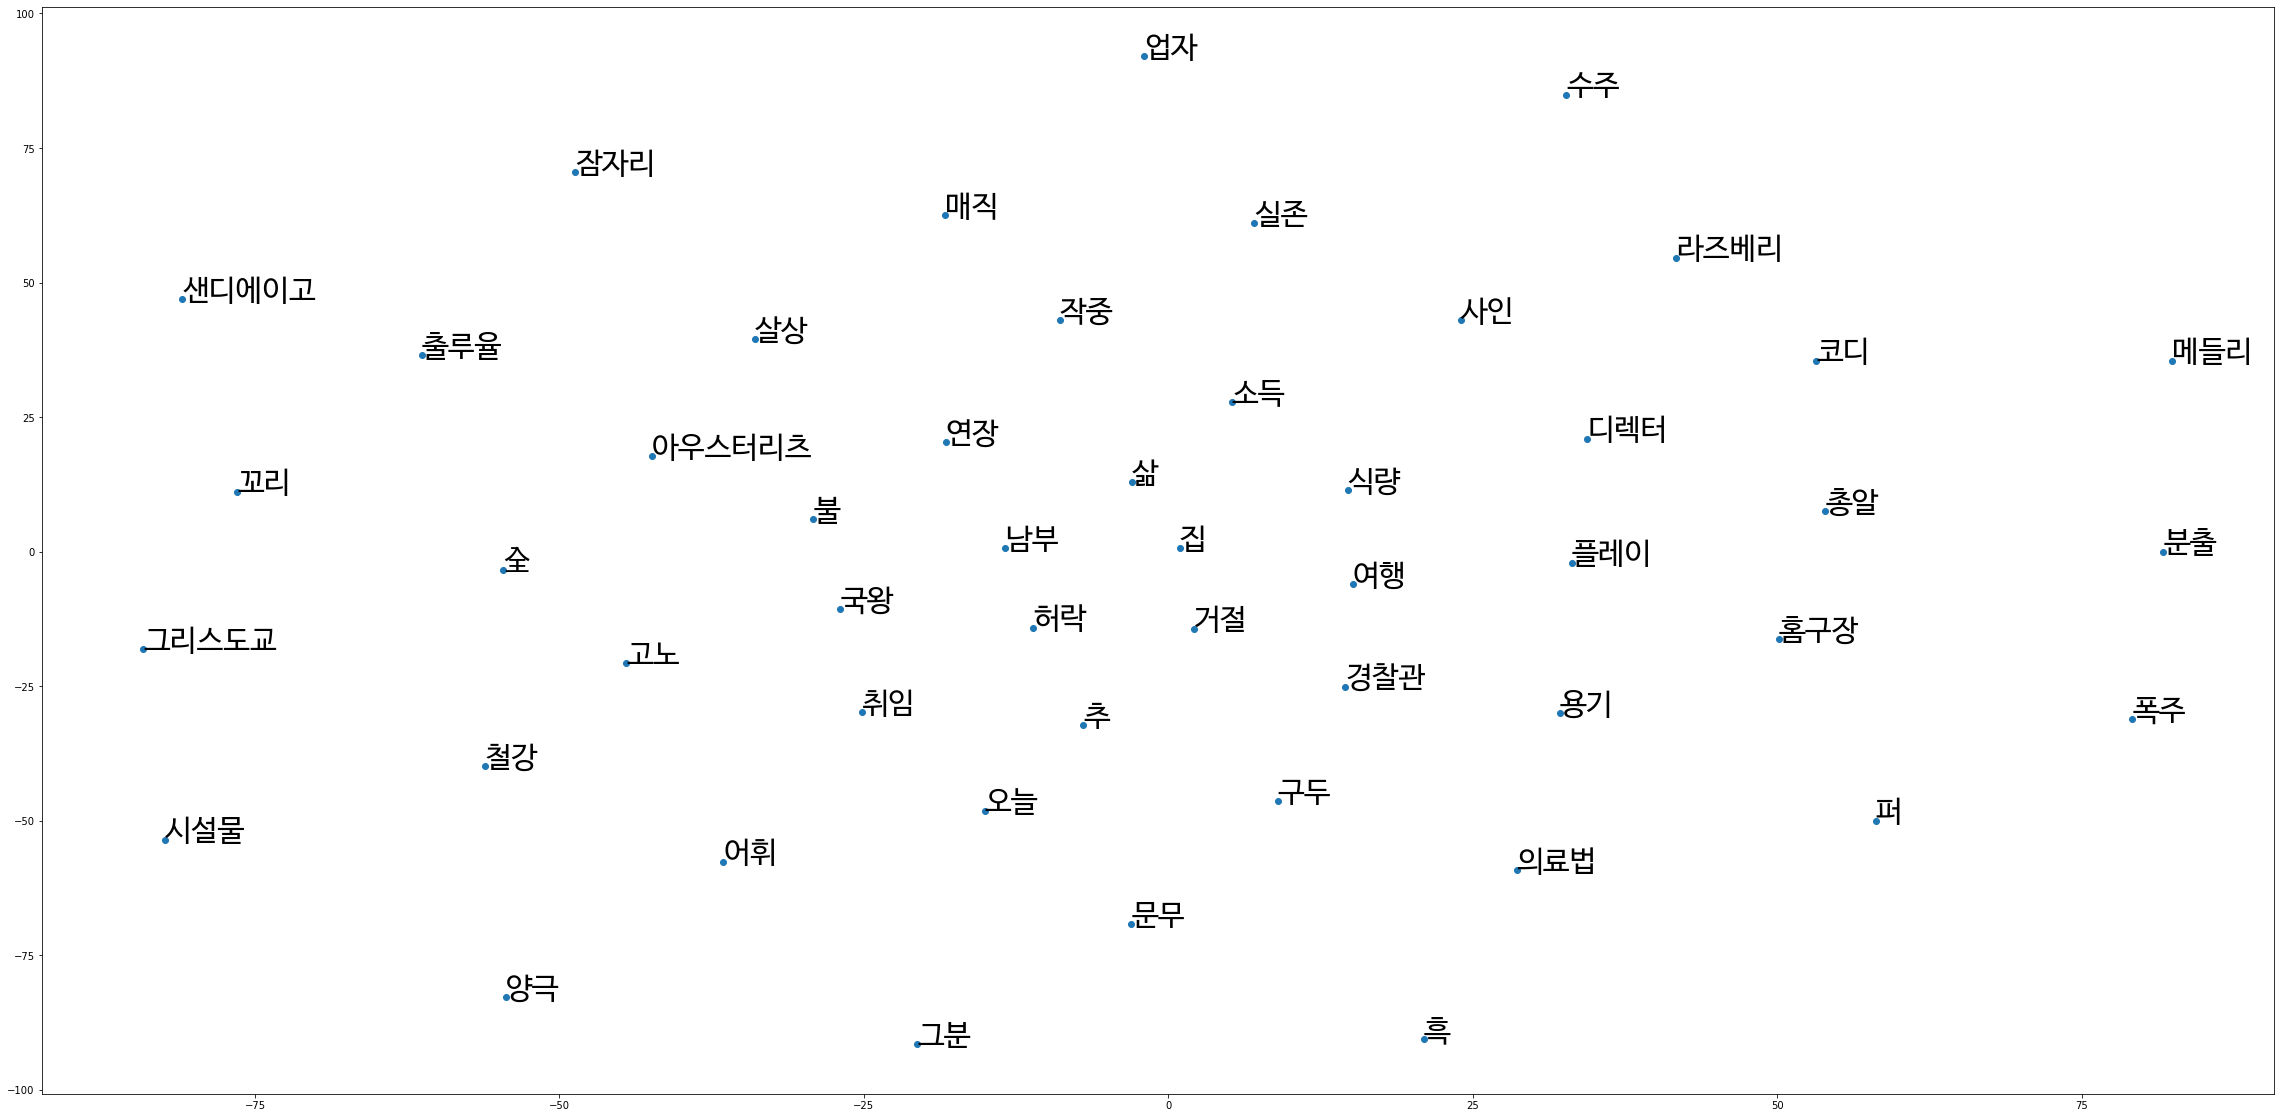

In [38]:
render_TSNE(random_vocab, word_emb) # TSNE 시각화

## 실습2: KorQuAD를 이용한 SentencePiece 학습

In [39]:
import sentencepiece as spm

### SentencePiece의 인풋에 맞도록 KorQuAD 데이터 전처리 후 저장

In [40]:
with open('./train_tokenizer.txt', 'w') as t:
    for i in range(len(dataset)):
        cur_par = dataset[i]['paragraphs']
        for j in range(len(cur_par)):
            cur_context = cur_par[j]['context'].split('.')
            for k in range(len(cur_context)):
                t.write(normalize_answer(cur_context[k]) + '.\n')  # 앞과 다르게 명사 외에도 모두 사용
        if i % 100 == 0:
            print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [41]:
with open('./train_tokenizer.txt', 'r') as t:
    a = t.read()

In [42]:
print(type(a))
a[:200]

<class 'str'>


'년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다.\n이 시기 바그너는 년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다.\n또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 번을 듣고'

In [43]:
# SentencePiece 하이퍼 파라미터 지정
input_file = './train_tokenizer.txt'  # 데이터 이름
vocab_size = 32000
model_name = 'subword_tokenizer_kor'  # 저장될 모델 이름
model_type = 'bpe'
user_defined_symbols = []

In [44]:
spm.SentencePieceTrainer.Train(input=input_file, model_prefix=model_name, vocab_size=vocab_size, 
                               user_defined_symbols=user_defined_symbols, model_type=model_type)

In [45]:
sp = spm.SentencePieceProcessor(model_file='subword_tokenizer_kor.model')
# sp = spm.SentencePieceProcessor(model_file='materials/subword_tokenizer_kor.model')

In [46]:
sp.encode('나는 학교에 간다.')

[1559, 8391, 9532, 29020]

In [47]:
sp.encode('나는 학교에 간다.', out_type=str)
# 띄어쓰기 나타내는 부분이 일반적인 _가 아니라는 점을 유의하자!

['▁나는', '▁학교에', '▁간다', '.']

In [48]:
with open('./subword_tokenizer_kor.vocab', encoding='utf-8') as f:  # SentencePieceProcessor automatically saves vocab file
    Vo = [doc.strip().split("\t") for doc in f]

In [49]:
word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [50]:
word2idx['나는']

827

In [51]:
sp.encode(normalize_answer(dataset[0]['paragraphs'][2]['context']), 'str')[:10]

['▁이', '▁작품은', '▁라', '단', '조', '▁아주', '▁신중', '하게', '▁박', '자의']

#### word2vec 학습에 맞도록 전처리

In [52]:
sentences = []

for i in range(len(dataset)):
    cur_par = dataset[i]['paragraphs']
    for j in range(len(cur_par)):
        cur_con = cur_par[j]['context']
        temp = [sp.encode(normalize_answer(x), 'str') for x in cur_con.split('.')]
        sentences = sentences + temp
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [53]:
# 파라메터값 지정
num_features = 100 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 단어빈도수가 10으로 제한
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 3 # epoch 수

In [54]:
# skip-gram 모델 학습
time_1 = time.time()
skip_gram_3 = word2vec.Word2Vec(sentences,
                                sg = 1, # skip-gram
                                negative=negative,
                                size=num_features, 
                                min_count=min_word_count,
                                window=window,
                                sample=downsampling,
                                iter=epoch)
time_2 = time.time()
print(time_2 - time_1)

18.86991238594055


In [55]:
vocab = list(skip_gram_3.wv.vocab) # vocab list 불러오기
len(vocab)

27730

In [56]:
skip_gram_3.save('skip_gram_bpe_3epoch.model')

In [57]:
# skip_gram_3 = word2vec.Word2Vec.load('materials/skip_gram_bpe.model')
skip_gram_3 = word2vec.Word2Vec.load('skip_gram_bpe_3epoch.model')

In [58]:
print(skip_gram_3.wv.most_similar('상'))

[('상을', 0.8321373462677002), ('상과', 0.8313006162643433), ('부문', 0.791077196598053), ('▁여자최우수연기', 0.7673554420471191), ('대상', 0.7528714537620544), ('조연', 0.7511124014854431), ('연기', 0.7505879998207092), ('▁우수', 0.748726487159729), ('▁여우조연', 0.7445994019508362), ('▁연기대상', 0.7374353408813477)]


In [59]:
print(skip_gram_3.wv.most_similar('▁상'))

[('▁외', 0.8570946455001831), ('▁웅', 0.8570220470428467), ('▁흑', 0.8545819520950317), ('▁서정', 0.854006290435791), ('▁조계', 0.8528045415878296), ('▁인원', 0.8513298630714417), ('▁소지', 0.8502326011657715), ('▁경찰서', 0.8492653369903564), ('▁장수', 0.8491767644882202), ('▁천지', 0.8490314483642578)]


In [60]:
skip_gram_3.wv.most_similar('▁천')

[('▁백만', 0.9065730571746826),
 ('▁천만', 0.8900556564331055),
 ('▁만원', 0.8813186883926392),
 ('▁억원', 0.8774229884147644),
 ('▁천여', 0.8697372674942017),
 ('▁달러', 0.8659259676933289),
 ('▁만', 0.861355721950531),
 ('▁원', 0.8591039180755615),
 ('▁원을', 0.8514164686203003),
 ('▁억', 0.8447689414024353)]

In [61]:
skip_gram_3.wv.most_similar('천')

[('궁', 0.9557843208312988),
 ('읍', 0.9322159290313721),
 ('삼', 0.9321655631065369),
 ('황', 0.9310937523841858),
 ('봉', 0.9300509691238403),
 ('춘', 0.9293698072433472),
 ('덕', 0.9288442730903625),
 ('련', 0.9272410869598389),
 ('강', 0.9270791411399841),
 ('▁전주', 0.9266793727874756)]

In [62]:
vector =  skip_gram_3["▁여름"] + skip_gram_3["바다"]
skip_gram_3.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('▁퐁텐', 0.9805982112884521),
 ('▁데이브', 0.9774086475372314),
 ('▁맥그리거는', 0.977212131023407),
 ('▁브로더릭', 0.9755085110664368),
 ('▁인터컨티넨탈', 0.97429358959198),
 ('▁베일의', 0.9741743803024292),
 ('▁멘', 0.974052906036377),
 ('▁챔피언쉽', 0.9740109443664551),
 ('▁세인트루이스', 0.9739543199539185),
 ('▁공백을', 0.9738357067108154)]

## 실습3: KorQuAD를 이용하여 POS tagging 해보기

In [63]:
from konlpy.tag import Twitter
twitter = Twitter()
# Twitter는 사용하는 품사 태그가 20개 정도 (Mecab는 50개 정도)

In [64]:
twitter.pos('나는 학교에 간다')

[('나', 'Noun'), ('는', 'Josa'), ('학교', 'Noun'), ('에', 'Josa'), ('간다', 'Noun')]

#### 태그비교표: https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [65]:
original_pos = ['Noun', 'Verb', 'Adjective', 'Determiner', 'Adverb', 'Conjunction', 
                'Exclamation', 'Josa', 'PreEomi', 'Eomi', 'Suffix', 'Punctuation', 
                'Foreign', 'Alpha', 'Number', 'Unknown', 'KoreanParticle', 
                'Hashtag', 'ScreenName', 'Email', 'URL','Modifier', 'VerbPrefix']
short_pos = ['N', 'V', 'A', 'D', 'B', 'C', 'E', 'J', 'P', 'F', 'S', 'G', 'H',
             'I', 'L', 'U', 'K', 'M', 'O', 'Q', 'R', 'T', 'W']

In [66]:
pos_dict = {}
for i, o in enumerate(original_pos):
    pos_dict[o] = short_pos[i]

pos_dict

{'Noun': 'N',
 'Verb': 'V',
 'Adjective': 'A',
 'Determiner': 'D',
 'Adverb': 'B',
 'Conjunction': 'C',
 'Exclamation': 'E',
 'Josa': 'J',
 'PreEomi': 'P',
 'Eomi': 'F',
 'Suffix': 'S',
 'Punctuation': 'G',
 'Foreign': 'H',
 'Alpha': 'I',
 'Number': 'L',
 'Unknown': 'U',
 'KoreanParticle': 'K',
 'Hashtag': 'M',
 'ScreenName': 'O',
 'Email': 'Q',
 'URL': 'R',
 'Modifier': 'T',
 'VerbPrefix': 'W'}

#### tag를 붙인 문서를 생성

In [67]:
time_1 = time.time()
with open('./train_tokenizer_pos.txt', 'w') as t:
    for i in range(len(dataset)):
        cur_par = dataset[i]['paragraphs']
        for j in range(len(cur_par)):
            cur_context = cur_par[j]['context'].split('.')
            for k in range(len(cur_context)):
                a = twitter.pos(normalize_answer(cur_context[k]))  # 품사를 구한 뒤
                a = [x[0] + pos_dict[x[1]] for x in a]             # 형태소에 품사를 붙여서 저장한다
                temp_result = ''
                for x in a:
                    temp_result = temp_result + x + ' '
                temp_result = temp_result[:-1]
                t.write(temp_result + '.\n')
        if i % 100 == 0:
            print(i)
time_2 = time.time()
print(time_2 - time_1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
210.24817276000977


In [68]:
with open('train_tokenizer_pos.txt', 'r') as t:
    a = t.read()

#### word vector 학습에 맞게 전처리

In [69]:
a_dot = a.split('.')

In [70]:
a_dot[0]

'년N 바그너N 는J 괴테N 의J 파우스트N 을N 처음N 읽고V 그N 내용N 에J 마음N 이J 끌려V 이를V 소재N 로J 해서V 하나N 의J 교향곡N 을J 쓰려는V 뜻N 을J 갖는다V'

In [71]:
sentences = []
for i, cur_sent in enumerate(a_dot):
    cur_sent = cur_sent.replace('\n', '')
    temp = [cur_sent.split(' ')]
    sentences = sentences + temp
    
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [72]:
with open("pos_sentences.json", 'w') as f:
    json.dump(sentences, f, indent=2) 

In [73]:
with open("pos_sentences.json", 'r') as f:
    sentences = json.load(f)

print(sentences[0])

['년N', '바그너N', '는J', '괴테N', '의J', '파우스트N', '을N', '처음N', '읽고V', '그N', '내용N', '에J', '마음N', '이J', '끌려V', '이를V', '소재N', '로J', '해서V', '하나N', '의J', '교향곡N', '을J', '쓰려는V', '뜻N', '을J', '갖는다V']


In [74]:
# 파라메터값 지정
num_features = 100 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 단어빈도수가 10으로 제한
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 3 # epoch 수

In [75]:
# skip-gram 모델 학습
time_1 = time.time()
skip_gram_6 = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)
time_2 = time.time()
print(time_2 - time_1)

15.468783855438232


In [76]:
skip_gram_6.save('skip_gram_pos_3epoch.model')

In [77]:
skip_gram_6 = word2vec.Word2Vec.load('skip_gram_pos_3epoch.model')

In [78]:
print(skip_gram_6.wv.most_similar('을J'))

[('만을J', 0.6395966410636902), ('도를V', 0.6388392448425293), ('지를V', 0.5984262228012085), ('사를V', 0.5946172475814819), ('시를A', 0.5834932923316956), ('하려V', 0.5830504894256592), ('이바지N', 0.582722544670105), ('배분N', 0.5800833702087402), ('되도록V', 0.579491138458252), ('헌신N', 0.5779653191566467)]


In [79]:
print(skip_gram_6.wv.most_similar('을N'))

[('기념관N', 0.9512825012207031), ('여수N', 0.9395638704299927), ('기로F', 0.9393854141235352), ('상무N', 0.9343947172164917), ('육군본부N', 0.9334691762924194), ('포항N', 0.9325878620147705), ('통합민주당N', 0.9318147301673889), ('창덕궁N', 0.9309324026107788), ('학내N', 0.927862286567688), ('송파구N', 0.9277769327163696)]
